In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet
from utils import MultiChannelNet

define function that initializes network

In [2]:
def get_untrained_net(training_dict,data_settings,model_name):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device", flush=True)
    model_paras=training_dict["model_paras"]

    action_space_dim = 2
    state_space_dim = data_settings['sys_parameters']['K']
    num_agents = data_settings['sys_parameters']['N']
    hidden_capacity = model_paras['hidden_capacity']
    # Initialize abstraction system model
    model_paras['model_name'] = model_name
    if model_paras['model_name'] == 'STOMPnet':
        # to match the M generated by joint policy of ground model set as: data_settings['sys_parameters']['jointagent_groundmodel_paras']['M']
        num_abs_agents = model_paras['M']
        abs_action_space_dim = model_paras['L']
        agent_embedding_dim = model_paras['nfeatures']
        assert (hidden_capacity/num_abs_agents).is_integer(
        ), "num of abstract agents should divide hidden dimensions"
        enc_hidden_dim = int(hidden_capacity/num_abs_agents)
        net = STOMPnet(
            state_space_dim,
            abs_action_space_dim,
            enc_hidden_dim,
            num_agents,
            num_abs_agents,
            action_space_dim=action_space_dim,
            agent_embedding_dim=agent_embedding_dim
        )
    elif model_paras['model_name'] == 'singletaskbaseline':
        assert (hidden_capacity /
                num_agents).is_integer(), "num of agents should divide hidden dimensions"
        net = MultiChannelNet(
            n_channels=num_agents,
            input_size=state_space_dim,
            hidden_layer_width=int(hidden_capacity/num_agents),
            output_size=action_space_dim
        )
    elif model_paras['model_name'] == 'multitaskbaseline':
        net = MultiChannelNet(
            n_channels=1,
            input_size=state_space_dim,
            hidden_layer_width=hidden_capacity,
            output_size=num_agents*action_space_dim,
            output_dim=(num_agents, action_space_dim)
        )
    else:
        print('choose valid model')
    net.to(device)
    return net
    

load data

In [3]:
data_settings_str =\
                '_4agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_1.0' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_1' +\
                '_K_5' +\
                '_N_4' +\
                '_T_512' +\
                '_sps_16'
#                 f'_g_8.0'
print(data_settings_str)
seed_idx = 0
#  '_singletaskbaseline' +\
#                 '_multitaskbaseline' +\
#  '_STOMPnet_M_2_L_4_nfeatures_2' +\
training_settings_str =\
 '_STOMPnet_M_2_L_100_nfeatures_2' +\
                '_cap_240' +\
                '_trainseed_0' +\
                '_epochs_200' +\
                '_batchsz_16' +\
                '_lr_5e-05'
print(training_settings_str)

_4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2_simulationdata_actsel_greedy_numepi_1_K_5_N_4_T_512_sps_16
_STOMPnet_M_2_L_100_nfeatures_2_cap_240_trainseed_0_epochs_200_batchsz_16_lr_5e-05


In [4]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()

data_root = out_dir +data_settings_str + f"_dataseed_{seed_idx}"
training_data = np.load(data_root+".npy", allow_pickle=True).item()
experiment_label = 'lossgoesdownexample'
training_root = out_dir + experiment_label + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str
training_dict = np.load(training_root + ".npy", allow_pickle=True).item()
trained_model_state_dict = torch.load(out_dir + data_settings_str + f"_dataseed_{seed_idx}"+training_settings_str + '_state_dict.pt')
import json
print('data_settings')
print(json.dumps(data_settings,sort_keys=True, indent=4))
print('\ntraining_data')
for key in trained_model_state_dict.keys():
    print(key+" "+str(trained_model_state_dict[key].requires_grad))
print(json.dumps(training_dict,sort_keys=True, indent=4))
print(f"\nmodel has {sum(p.numel() for p in trained_model_state_dict.values())} parameters grouped as:")

data_settings
{
    "actsel": "greedy",
    "dataset_label": "4agentdebug_modelname_bitpop_corr_1.0_ensemble_sum_M_2",
    "episode_length": 512,
    "num_episodes": 1,
    "num_seeds": 10,
    "sys_parameters": {
        "K": 5,
        "N": 4,
        "action_space_dim": 2,
        "jointagent_groundmodel_paras": {
            "M": 2,
            "corr": 1.0,
            "ensemble": "sum",
            "modelname": "bitpop"
        },
        "samples_per_state": 16
    }
}

training_data
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.weight False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.bias False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.weight False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.bias False
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.weight False
sample_from_abstract_joint_policy.

Initialize and count parameters

In [17]:
N_vec = 4*np.power(5,np.arange(5)) #short run
# N_vec = 4*np.power(5,np.arange(6)) #long run
paras={}
for model_name in ['STOMPnet', 'singletaskbaseline','multitaskbaseline']:
    if model_name=='singletaskbaseline':
        hC_vec=256*N_vec
    elif model_name=='STOMPnet':
        training_dict['model_paras']['nfeatures'] = 256
        hC_vec=360*np.ones(N_vec.shape)
    else:
        hC_vec=np.round(np.sqrt(0.8e5*N_vec)/N_vec).astype(int)*N_vec
    paras[model_name] = []
    for N, hC in zip(N_vec,hC_vec):
        data_settings['sys_parameters']['N']=N
#         data_settings['sys_parameters']['K']=10
        training_dict['model_paras']['hidden_capacity'] = hC
        net=get_untrained_net(training_dict,data_settings,model_name)
        state_dict=net.state_dict()
        paras[model_name].append(sum(p.numel() for p in state_dict.values()))
        for key in state_dict.keys():
            print(key+" "+str(list(state_dict[key].size())))
#         if model_name == 'STOMPnet':
#             print(net.ground_joint_policy.ground_agent_embedding.weight.size())
#             print(net.assigner.abs_agent_assignment_embedding.weight.size())

Using cpu device
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.weight [180, 10]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.weight [180, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.weight [180, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.3.weight [100, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.3.bias [100]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.1.0.weight [180, 10]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.1.0.bias [180]
sample_from_abstract

sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.weight [180, 10]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.0.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.weight [180, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.1.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.weight [180, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.2.bias [180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.3.weight [100, 180]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.0.3.bias [100]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.1.0.weight [180, 10]
sample_from_abstract_joint_policy.abstract_agent_policy_networks.module_array.1.0.bias [180]
sample_from_abstract_joint_policy.abs

module_array.0.0.weight [256, 10]
module_array.0.0.bias [256]
module_array.0.1.weight [256, 256]
module_array.0.1.bias [256]
module_array.0.2.weight [256, 256]
module_array.0.2.bias [256]
module_array.0.3.weight [2, 256]
module_array.0.3.bias [2]
module_array.1.0.weight [256, 10]
module_array.1.0.bias [256]
module_array.1.1.weight [256, 256]
module_array.1.1.bias [256]
module_array.1.2.weight [256, 256]
module_array.1.2.bias [256]
module_array.1.3.weight [2, 256]
module_array.1.3.bias [2]
module_array.2.0.weight [256, 10]
module_array.2.0.bias [256]
module_array.2.1.weight [256, 256]
module_array.2.1.bias [256]
module_array.2.2.weight [256, 256]
module_array.2.2.bias [256]
module_array.2.3.weight [2, 256]
module_array.2.3.bias [2]
module_array.3.0.weight [256, 10]
module_array.3.0.bias [256]
module_array.3.1.weight [256, 256]
module_array.3.1.bias [256]
module_array.3.2.weight [256, 256]
module_array.3.2.bias [256]
module_array.3.3.weight [2, 256]
module_array.3.3.bias [2]
module_array

module_array.0.0.weight [256, 10]
module_array.0.0.bias [256]
module_array.0.1.weight [256, 256]
module_array.0.1.bias [256]
module_array.0.2.weight [256, 256]
module_array.0.2.bias [256]
module_array.0.3.weight [2, 256]
module_array.0.3.bias [2]
module_array.1.0.weight [256, 10]
module_array.1.0.bias [256]
module_array.1.1.weight [256, 256]
module_array.1.1.bias [256]
module_array.1.2.weight [256, 256]
module_array.1.2.bias [256]
module_array.1.3.weight [2, 256]
module_array.1.3.bias [2]
module_array.2.0.weight [256, 10]
module_array.2.0.bias [256]
module_array.2.1.weight [256, 256]
module_array.2.1.bias [256]
module_array.2.2.weight [256, 256]
module_array.2.2.bias [256]
module_array.2.3.weight [2, 256]
module_array.2.3.bias [2]
module_array.3.0.weight [256, 10]
module_array.3.0.bias [256]
module_array.3.1.weight [256, 256]
module_array.3.1.bias [256]
module_array.3.2.weight [256, 256]
module_array.3.2.bias [256]
module_array.3.3.weight [2, 256]
module_array.3.3.bias [2]
module_array

module_array.0.0.weight [256, 10]
module_array.0.0.bias [256]
module_array.0.1.weight [256, 256]
module_array.0.1.bias [256]
module_array.0.2.weight [256, 256]
module_array.0.2.bias [256]
module_array.0.3.weight [2, 256]
module_array.0.3.bias [2]
module_array.1.0.weight [256, 10]
module_array.1.0.bias [256]
module_array.1.1.weight [256, 256]
module_array.1.1.bias [256]
module_array.1.2.weight [256, 256]
module_array.1.2.bias [256]
module_array.1.3.weight [2, 256]
module_array.1.3.bias [2]
module_array.2.0.weight [256, 10]
module_array.2.0.bias [256]
module_array.2.1.weight [256, 256]
module_array.2.1.bias [256]
module_array.2.2.weight [256, 256]
module_array.2.2.bias [256]
module_array.2.3.weight [2, 256]
module_array.2.3.bias [2]
module_array.3.0.weight [256, 10]
module_array.3.0.bias [256]
module_array.3.1.weight [256, 256]
module_array.3.1.bias [256]
module_array.3.2.weight [256, 256]
module_array.3.2.bias [256]
module_array.3.3.weight [2, 256]
module_array.3.3.bias [2]
module_array

module_array.0.0.weight [564, 10]
module_array.0.0.bias [564]
module_array.0.1.weight [564, 564]
module_array.0.1.bias [564]
module_array.0.2.weight [564, 564]
module_array.0.2.bias [564]
module_array.0.3.weight [8, 564]
module_array.0.3.bias [8]
Using cpu device
module_array.0.0.weight [1260, 10]
module_array.0.0.bias [1260]
module_array.0.1.weight [1260, 1260]
module_array.0.1.bias [1260]
module_array.0.2.weight [1260, 1260]
module_array.0.2.bias [1260]
module_array.0.3.weight [40, 1260]
module_array.0.3.bias [40]
Using cpu device
module_array.0.0.weight [2800, 10]
module_array.0.0.bias [2800]
module_array.0.1.weight [2800, 2800]
module_array.0.1.bias [2800]
module_array.0.2.weight [2800, 2800]
module_array.0.2.bias [2800]
module_array.0.3.weight [200, 2800]
module_array.0.3.bias [200]
Using cpu device
module_array.0.0.weight [6500, 10]
module_array.0.0.bias [6500]
module_array.0.1.weight [6500, 6500]
module_array.0.1.bias [6500]
module_array.0.2.weight [6500, 6500]
module_array.0.2.

plot

Text(0.5, 0, '# agents, $N$')

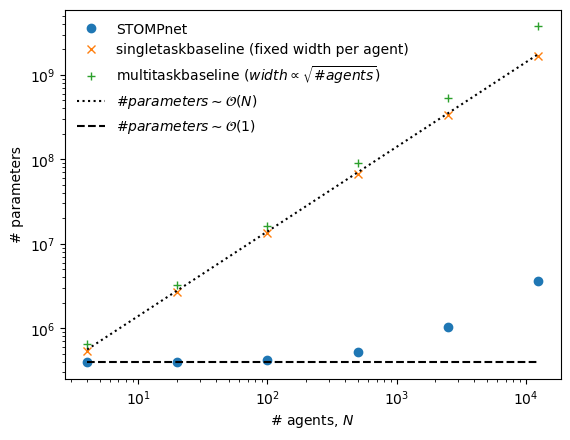

In [13]:
fig,ax=pl.subplots()
mkr=['o','x','+']
# ax.plot(N_vec,0.8e4*N_vec**2,'k--',label=r'$y\propto x^2$')
for mit,model_name in enumerate(['STOMPnet', 'singletaskbaseline','multitaskbaseline']):
    if mit==0:
        strvar=''
    elif mit==1:
        strvar=r' (fixed width per agent)'
    else:
        strvar=r' ($width\propto \sqrt{\# agents}$)'
    ax.plot(N_vec,paras[model_name],mkr[mit],label=model_name+strvar)

ax.plot(N_vec,1.4e5*N_vec,'k:',label=r'$\# parameters\sim\mathcal{O}(N)$')
ax.plot(N_vec,4e5*np.ones(N_vec.shape),'k--',label=r'$\# parameters\sim\mathcal{O}(1)$')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(frameon=False)
ax.set_ylabel("# parameters")
ax.set_xlabel("# agents, $N$")

count

In [30]:
def solve_quadratic(a,b,c):
    return (-b+np.sqrt(b**2-4*a*c))/(2*a) #assumes negative root always extraneous

def get_width(num_paras,N,model_name):
    H=2 #number of hidden layers
    A=2 #action_space_dim
    K=10 #state_space_dim
    P=num_paras
    if model_name=='singletaskbaseline':
        a=H
        b=N*(A+K)
        c=-P
        W=solve_quadratic(a,b,c)
    elif model_name=='multitaskbaseline':
        a=H
        b=N*A+K
        c=-P
        W=solve_quadratic(a,b,c)
    elif model_name=='STOMPnet':
        enc2dec_ratio = 1
        L=1000 #num_abs_actions
        M=2 #num_abs_agents
        F=256 #num_features
        a=(M+enc2dec_ratio**2)*H
        b=(M*L+K) + (F+L+A)*enc2dec_ratio
        c=N*M-P
        W=solve_quadratic(a,b,c)
    else:
        print('choose valid model name')
    return W

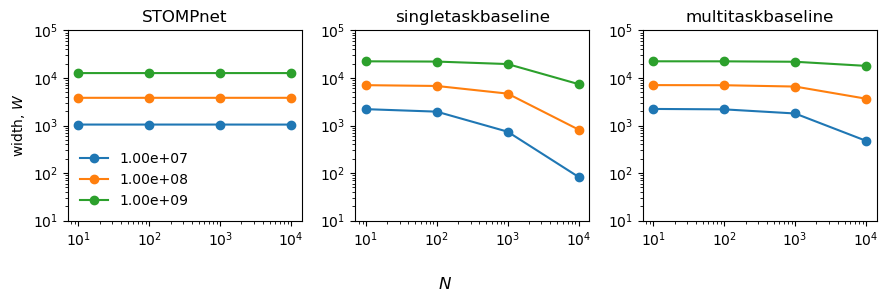

In [42]:
fig,ax=pl.subplots(1,3,figsize=(9,3))
Nvec=[1e1,1e2,1e3,1e4]
Pvec= [1e7,1e8,1e9]
for mit,model_name in enumerate(['STOMPnet', 'singletaskbaseline','multitaskbaseline']):
    for num_paras in Pvec:
        Wvec=[]
        for N in Nvec:
            Wvec.append(get_width(num_paras,N,model_name))
        ax[mit].plot(Nvec,Wvec,'o-',label="{:.2e}".format(num_paras))
    ax[mit].set_yscale('log')
    ax[mit].set_xscale('log')
    ax[mit].set_ylim(1e1,1e5)
    ax[mit].set_title(model_name)
ax[0].set_ylabel('width, $W$')
ax[0].legend(frameon=False)  
fig.supxlabel(r'$N$')
fig.tight_layout()
